<a href="https://colab.research.google.com/github/mcpinto1993/Kaggle_StoreSales/blob/main/StoreSalesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📝Store Sales Analysis⏳ Time Serie**

### **Load Data From Kaggle**

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download store-sales-time-series-forecasting

! unzip store-sales-time-series-forecasting.zip

### **Read Data**

In [6]:
import pandas as pd

In [13]:
oil = pd.read_csv('/content/oil.csv')
stores = pd.read_csv('/content/stores.csv')
transactions = pd.read_csv('/content/transactions.csv')
test = pd.read_csv('/content/test.csv')
train = pd.read_csv('/content/train.csv')
holidays_events = pd.read_csv('/content/holidays_events.csv')

### **Stores Analysis**

In [ ]:
print("Column Types:\n{} \n".format(stores.dtypes))
print("DataFrame statistics: \n {} \n".format(stores.describe()))
print("Null Values: \n{} \n".format(stores.isnull().sum()))
print("Unique Values: \n{}".format(stores.nunique()))

In [79]:
#Total Nr of Stores -- 54
Total_NrStores = len(stores['store_nbr'].unique())

#Nr Of Stores By City, State and Type
NrStoresByCity = stores['city'].value_counts()
NrStoresByState = stores['state'].value_counts()
NrStoresByType = stores['type'].value_counts()

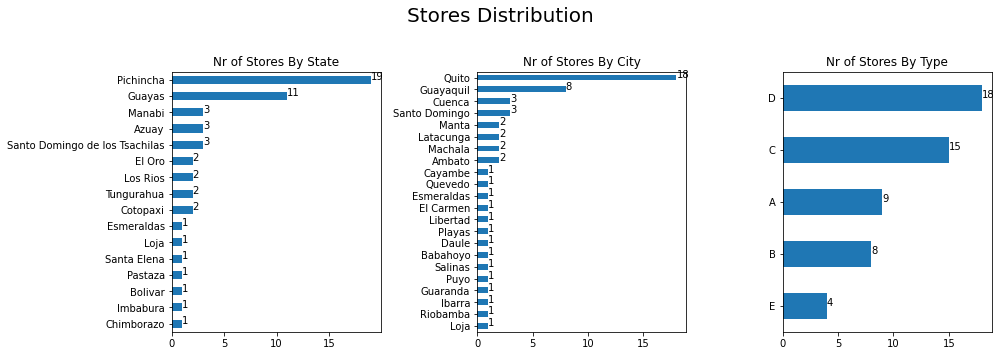

In [155]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.subplot(1,3,1)
NrStoresByState.sort_values().plot(kind='barh', figsize = (14,5), edgecolor = 'none')
plt.title("Nr of Stores By State")
for index, value in enumerate(NrStoresByState.sort_values()):
    plt.text(value, index,
             str(value))

plt.subplot(1,3,2)
NrStoresByCity.sort_values().plot(kind='barh', figsize = (14,5))
plt.title("Nr of Stores By City")
for index, value in enumerate(NrStoresByCity.sort_values()):
    plt.text(value, index,
             str(value))

plt.subplot(1,3,3)
NrStoresByType.sort_values().plot(kind='barh', figsize = (14,5))
plt.title("Nr of Stores By Type")
for index, value in enumerate(NrStoresByType.sort_values()):
    plt.text(value, index,
             str(value))

plt.tight_layout()
fig.suptitle("Stores Distribution", fontsize=20)
fig.subplots_adjust(hspace=0.4, top=0.8)
plt.show()